# This Notebook is to test the branch tasks of LangGraph

The branch tasks are:

* A router agent to determine the task
* 2 tool calling agents to perform task routed from the router agent
* This is chat app instead of a 1 pass tasks

In [ ]:
from langchain.agents.agent import RunnableAgent
from langgraph.prebuilt import ToolNode
%pip install -r ../requirements.txt --quiet
%restart_python

In [42]:
local = True

if local:
    from databricks.connect import DatabricksSession
    from dotenv import load_dotenv

    spark = DatabricksSession.builder.getOrCreate()
    load_dotenv('../.env')

    DATABRICKS_HOST = os.getenv('host')
    DATABRICKS_TOKEN = os.getenv('token')
    OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
else:
    DATABRICKS_HOST = dbutils.notebook.entry_point.getDbutils().notebook().getContext().apiUrl().get()
    OPENAI_API_KEY = dbutils.secrets.get("databricks_token_qyu", "OpenAi")

print(f"host: {DATABRICKS_HOST}")

%load_ext autoreload
%autoreload 2

host: adb-984752964297111.11.azuredatabricks.net
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
from unitycatalog.ai.core.base import set_uc_function_client
from unitycatalog.ai.core.databricks import DatabricksFunctionClient

client = DatabricksFunctionClient()
set_uc_function_client(client)

CATALOG = 'dhuang'
SCHEMA = 'insurance_agent'

In [44]:
from typing import Any, Generator, Optional, Sequence, Union, TypedDict, Dict, List
from typing_extensions import Literal

import mlflow
from pydantic import BaseModel, Field
from databricks_langchain import ChatDatabricks, VectorSearchRetrieverTool
from databricks_langchain.uc_ai import (
    DatabricksFunctionClient,
    UCFunctionToolkit,
    set_uc_function_client,
)
from langchain_core.language_models import LanguageModelLike
from langchain_core.runnables import RunnableConfig, RunnableLambda
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage, SystemMessage
from langchain_core.tools import BaseTool
from langgraph.prebuilt.tool_node import ToolNode
from langgraph.graph import END, StateGraph, START
from langgraph.graph.graph import CompiledGraph
from langgraph.graph.state import CompiledStateGraph
from mlflow.langchain.chat_agent_langgraph import ChatAgentState, ChatAgentToolNode
from mlflow.pyfunc import ChatAgent
from mlflow.types.agent import (
    ChatAgentChunk,
    ChatAgentMessage,
    ChatAgentResponse,
    ChatContext,
)

if local:
    mlflow.set_tracking_uri("http://localhost:5000")
    mlflow.set_registry_uri("http://localhost:5000")
    mlflow.set_experiment("langgraph_test")
else:
    mlflow.set_tracking_uri("databricks")
    mlflow.set_registry_uri("databricks-uc")
    mlflow.set_experiment("/Users/q.yu@databricks.com/ML_experiments/ml_doc_agent")

mlflow.langchain.autolog()

In [45]:
############################################
# Define your LLM endpoint and system prompt
############################################
LLM_ENDPOINT_NAME = "databricks-claude-3-7-sonnet"
LLM = ChatDatabricks(endpoint=LLM_ENDPOINT_NAME)

RECOMMENDED_PROMPT_PREFIX = """
    # System context
    You are part of a multi-agent system, designed to make agent coordination and execution easy.
    Agents uses two primary abstraction: **Agents** and **Handoffs**.
    An agent encompasses instructions and tools and can hand off a conversation to another agent when appropriate.
    Handoffs are achieved by calling a handoff function, generally named `transfer_to_<agent_name>`.
    Transfers between agents are handled seamlessly in the background; do not mention or draw attention to these transfers in your conversation with the user.
"""

TRIAGE_PROMPT = """
    You are a helpful triaging agent.
    You can use your tools to delegate questions to other appropriate agents.
    If the customer does not have anymore questions, wish them a goodbye and a good rest of their day.
"""

CLAIMS_DETAIL_RETRIEVAL_PROMPT = """
    You are a claims details retrieval agent.
    If you are speaking to a customer, you probably were transferred to you from the triage agent.
    Use the following routine to support the customer.
    # Routine:
    1. Identify the last question asked by the customer.
    2. Use the search tools to retrieve data about a claim. Do not rely on your own knowledge.
    3. If you cannot answer the question, transfer back to the triage agent.
"""

POLICY_QA_AGENT_PROMPT = """
    You are an insurance policy Q&A agent.
    If you are speaking to a customer, you probably were transferred to you from the triage agent.
    Use the following routine to support the customer.
    # Routine:
    1. Identify the last question asked by the customer.
    2. Use the search tools to answer the question about their policy. Do not rely on your own knowledge.
    3. If you cannot answer the question, transfer back to the triage agent.
"""

/var/folders/b3/rdsklr3d0s1f_fzq3pg5try40000gp/T/ipykernel_1143/2156233689.py:5: DeprecationWarning: Currently, temperature defaults to 0.0 if not specified. In the next release, temperature will need to be explicitly set. Please update your code to specify a temperature value. Note: If you are using an o1 or o3 model, you need to set temperature=None.
  LLM = ChatDatabricks(endpoint=LLM_ENDPOINT_NAME)


## Create a Tool Calling Agent function

In [46]:
def create_tool_calling_agent(model: LanguageModelLike,
                              tools: Union[ToolNode, Sequence[BaseTool]],
                              system_prompt: Optional[str] = None,
                              ) -> CompiledGraph:
    """Creates an agent for handling claim detail retrieval requests."""

    # Bind tools to the model
    model = model.bind_tools(tools)

    # Define the function that determines which node to go to
    def should_continue(state: ChatAgentState):
        messages = state["messages"]
        last_message = messages[-1]
        # If there are function calls, continue. else, end
        if last_message.get("tool_calls"):
            return "continue"
        else:
            return "end"

    # Create the message preprocessor with system prompt
    if system_prompt:
        preprocessor = RunnableLambda(
            lambda state: [{"role": "system", "content": system_message}]
                          + state["messages"]
        )
    else:
        preprocessor = RunnableLambda(lambda state: state["messages"])
    model_runnable = preprocessor | model

    # Define the call_model function
    def call_model(
            state: ChatAgentState,
            config: RunnableConfig
    ):
        response = model_runnable.invoke(state, config)
        return {"messages": state["messages"] + [response]}

    # Create the workflow graph
    workflow = StateGraph(ChatAgentState)
    workflow.add_node("agent", RunnableLambda(call_model))
    workflow.add_node("tools", ChatAgentToolNode(tools))
    workflow.set_entry_point("agent")
    workflow.add_conditional_edges(
        "agent",
        should_continue,
        {
            "continue": "tools",
            "end": END,
        },
    )
    workflow.add_edge("tools", "agent")
    return workflow.compile()


## Define Triage Agent (Rounter)

In [47]:
def create_triage_agent(model: LanguageModelLike,
                        system_prompt: Optional[str] = None,
                        ) -> RunnableLambda:
    """Create a triage agent to route the input to the appropriate tool agent"""

    def triage_query(state: ChatAgentState, config: RunnableConfig):
        user_messages = [msg for msg in state['messages'] if msg.get("role") == "user"]

        if not user_messages:
            return {"route": "need clarification"}

        latest_user_msg = user_messages[-1]
        user_query = latest_user_msg.get("content", "")

        # Prepare classification request
        messages = [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": f"customer question: {user_query}"}
        ]

        # Get classification from the model
        response = model.invoke(messages)
        classification = response.content.strip().lower()

        # Determine routing based on classification
        if "claim" in classification:
            return {"route": "claim_detail_retrieval"}
        elif "policy" in classification:
            return {"route": "policy_questions"}
        else:
            return {"route": "policy_questions"}

    return RunnableLambda(triage_query)

## Create multi-agent workflow

In [48]:
uc_tool_name = [f"{CATALOG}.{SCHEMA}.{func.name}" for func in client.list_functions(catalog=CATALOG,
                                                                                    schema=SCHEMA)]
selected_uc_tool_names = uc_tool_name[:2]
print(selected_uc_tool_names)

['dhuang.insurance_agent.policy_docs_vector_search', 'dhuang.insurance_agent.search_claims_details_by_policy_no']


In [49]:
tools = []
uc_toolkit = UCFunctionToolkit(function_names=selected_uc_tool_names)
tools.extend(uc_toolkit.tools)

In [56]:
triage_agent = create_triage_agent(LLM, TRIAGE_PROMPT)
claim_agent = create_tool_calling_agent(LLM, [tools[1]], CLAIMS_DETAIL_RETRIEVAL_PROMPT)
policy_agent = create_tool_calling_agent(LLM, [tools[0]], POLICY_QA_AGENT_PROMPT)

def route_to_agent(state: ChatAgentState):
    route = state.get("route")
    if route == "claim_detail_retrieval":
        return "claim_agent"
    elif route == "policy_questions":
        return "policy_agent"
    else:
        raise ValueError(f"Unknown route: {route}")

## Create the multi-agent workflow

In [57]:
workflow = StateGraph(ChatAgentState)

# Add nodes
workflow.add_node("triage_agent", triage_agent)
workflow.add_node("claim_agent", claim_agent)
workflow.add_node("policy_agent", policy_agent)

# Add edges
workflow.set_entry_point("triage_agent")
workflow.add_conditional_edges(
    "triage_agent",
    route_to_agent,
    {
        "claim_detail_retrieval": "claim_agent",
        "policy_questions": "policy_agent",
    }
)
workflow.add_edge("claim_agent", END)
workflow.add_edge("policy_agent", END)

# Shall I add these edges to return to the triage agent for new questions?
# workflow.add_edge("claim_agent", "triage_agent")
# workflow.add_edge("policy_agent", "triage_agent")

insurance_agent_workflow = workflow.compile()

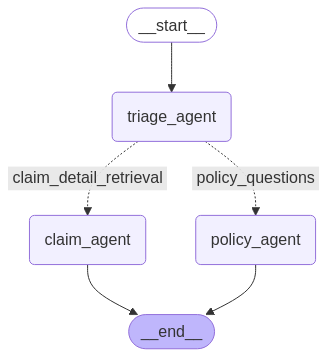

In [58]:
from IPython.display import Image, display

display(Image(insurance_agent_workflow.get_graph().draw_mermaid_png()))

## Create ChatAgent Model

In [59]:
class InsuranceMultiAgentChatAgent(ChatAgent):
    """MLflow ChatAgent implementation for the insurance multi-agent workflow."""

    def __init__(self, agent: CompiledGraph):
        self.agent = agent

    def predict(
        self,
        messages: List[ChatAgentMessage],
        context: Optional[ChatContext] = None,
        custom_inputs: Optional[Dict[str, Any]] = None,
    ) -> ChatAgentResponse:
        """Processes a conversation and returns a response."""
        request = {"messages": self._convert_messages_to_dict(messages)}

        # Execute the workflow
        result = self.agent.invoke(request)

        # Convert messages to ChatAgentMessage format
        response_messages = []
        for node_name, node_data in result.items():
            if isinstance(node_data, dict) and "messages" in node_data:
                for msg in node_data["messages"]:
                    if isinstance(msg, dict):
                        response_messages.append(ChatAgentMessage(**msg))

        return ChatAgentResponse(messages=response_messages)

    def predict_stream(
        self,
        messages: List[ChatAgentMessage],
        context: Optional[ChatContext] = None,
        custom_inputs: Optional[Dict[str, Any]] = None,
    ) -> Generator[ChatAgentChunk, None, None]:
        """Streams the agent's response."""
        request = {"messages": self._convert_messages_to_dict(messages)}

        # Stream the workflow execution
        for event in self.agent.stream(request, stream_mode="updates"):
            for node_data in event.values():
                if isinstance(node_data, dict) and "messages" in node_data:
                    for msg in node_data["messages"]:
                        if isinstance(msg, dict):
                            yield ChatAgentChunk(delta=msg)


In [60]:
AGENT = InsuranceMultiAgentChatAgent(insurance_agent_workflow)
mlflow.models.set_model(AGENT)

In [61]:
result = AGENT.predict({"messages": [{"role": "user", "content": "hi, id like to check on my existing claims"}]})

ValueError: Unknown route: None

Trace(request_id=70f8e6f48bcf4583abdccd855e8607d4)